In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

In [2]:
import pandas as pd

In [5]:
from dataloaders import *

In [6]:
from model_classes import *

In [7]:
ld_val = Lung_Val_Dataset1()
ld_test = Lung_Test_Dataset1()
ld_train = Lung_Train_Dataset1()

ld_val2 = Lung_Val_Dataset2()
ld_test2 = Lung_Test_Dataset2()
ld_train2 = Lung_Train_Dataset2()

ld_val3 = Lung_Val_Dataset3()
ld_test3 = Lung_Test_Dataset3()
ld_train3 = Lung_Train_Dataset3()

In [8]:
bs_val = 32

In [9]:
# Dataloader from dataset
train_loader = DataLoader(ld_train, batch_size = bs_val, shuffle = True)
test_loader = DataLoader(ld_test, batch_size = bs_val, shuffle = True)
val_loader = DataLoader(ld_val, batch_size = bs_val, shuffle = True)

# Dataloader from dataset2
train_loader2 = DataLoader(ld_train2, batch_size = bs_val, shuffle = True)
test_loader2 = DataLoader(ld_test2, batch_size = bs_val, shuffle = True)
val_loader2 = DataLoader(ld_val2, batch_size = bs_val, shuffle = True)

# Dataloader from dataset3
train_loader3 = DataLoader(ld_train3, batch_size = bs_val, shuffle = True)
test_loader3 = DataLoader(ld_test3, batch_size = bs_val, shuffle = True)
val_loader3 = DataLoader(ld_val3, batch_size = bs_val, shuffle = True)

In [10]:
def get_model_name(model_name, model_obj, optimizer_obj):
  checkpoint = torch.load("models/" + model_name)
  model_obj.load_state_dict(checkpoint['model_state_dict'])
  optimizer_obj.load_state_dict(checkpoint['optimizer_state_dict'])
  return model_obj, optimizer_obj

#declare defaults

model1 = Net2()
optimizer1 = optim.Adam(model1.parameters())
model1, optimizer1 = get_model_name("model1_1_epoch6.pth", model1, optimizer1)
model1.eval()

model2 = Net2()
optimizer2 = optim.Adam(model2.parameters())
model2, optimizer2 = get_model_name("model2_infected_noninfected_2.pth", model2, optimizer2)
model2.eval()

model3 = Net3()
optimizer3 = optim.Adam(model3.parameters())
model3, optimizer3 = get_model_name("model3_all3_1.pth", model3, optimizer3)
model3.eval()

Net3(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(16, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (pool2): AvgPool2d(kernel_size=3, stride=3, padding=0)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=57600, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=3, bias=True)
)

In [11]:
#function to get confusion matrix for model1 -> model2 pipeline
def get_combined_model_predictions(model1, model2, test_loader3):
  confusion_matrix = torch.zeros(3, 3)
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(test_loader3):
          #get model1 output for each input
          outputs = model1(inputs)
          #get model 1 predictions
          _, preds = torch.max(outputs, 1)
          _, y_actual = torch.max(classes, 1)

          #create a 
          preds2 = torch.clone(preds)

          for k in range(len(preds)):
            #if prediction is normal (0), label it as 2
            if preds[k].item() == 0:
              preds2[k] = 2
            else:
              #get model2 output for each input
              model2_output = model2(torch.FloatTensor([inputs[k].numpy()]))
              #get model2 prediction
              _, model2_pred = torch.max(model2_output, 1)
              preds2[k] = model2_pred[0].item()

          for t, p in zip(y_actual.view(-1), preds2.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1
  return confusion_matrix  

In [12]:
#function to get confusion matrix for a model and a given dataset
def get_confusion_matrix(model, validation_set, nb_classes):
  confusion_matrix = torch.zeros(nb_classes, nb_classes)
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(validation_set):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          _, y_actual = torch.max(classes, 1)
          for t, p in zip(y_actual.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1
  return confusion_matrix

In [13]:
#will take a bit of time to run
confusion1 = get_confusion_matrix(model1, test_loader, 2)
confusion2 = get_confusion_matrix(model2, test_loader2, 2)
confusion3 = get_confusion_matrix(model3, test_loader3, 3)

In [14]:
confusion_matrix_3 = get_combined_model_predictions(model1, model2, test_loader3)

In [15]:
#first confusion matrix
print("Confusion-Matrix for model1: normal/infected")
print(confusion1)
print("\n")
print("Class-wise accuracies for model1: normal/infected")
print(confusion1.diag()/confusion1.sum(1))

Confusion-Matrix for model1: normal/infected
tensor([[134., 100.],
        [ 12., 369.]])


Class-wise accuracies for model1: normal/infected
tensor([0.5726, 0.9685])


In [16]:
#Train, Test, Accuracy Curves for model1
df1 = pd.read_excel("training_logs/model1_1.xlsx")
df1.columns

Index(['train_loss', 'test_loss', 'accuracy'], dtype='object')

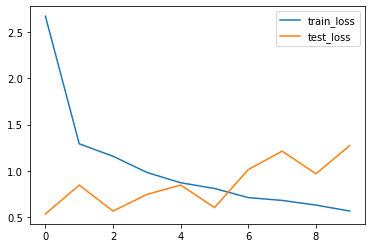

In [17]:
plt.plot(df1["train_loss"])
plt.plot(df1["test_loss"])
plt.legend(df1.columns[:2])

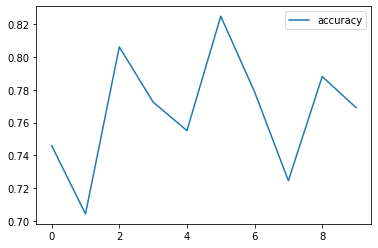

In [18]:
plt.plot(df1["accuracy"])
plt.legend(df1.columns[2:3])

In [19]:
#Second confusion matrix
print("Confusion-Matrix for model2: covid/non-covid")
print(confusion2)
print("\n")
print("Class-wise accuracies for model1: covid/non-covid")
print(confusion2.diag()/confusion2.sum(1))

Confusion-Matrix for model2: covid/non-covid
tensor([[108.,  31.],
        [  5., 237.]])


Class-wise accuracies for model1: covid/non-covid
tensor([0.7770, 0.9793])


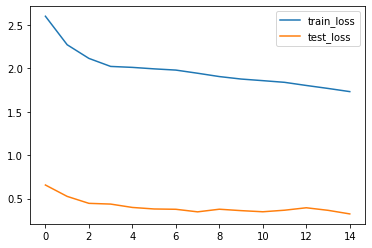

In [20]:
df2 = pd.read_excel("training_logs/model2_infected_noninfected_2.xlsx")
plt.plot(df2["train_loss"])
plt.plot(df2["test_loss"])
plt.legend(df2.columns[:2])

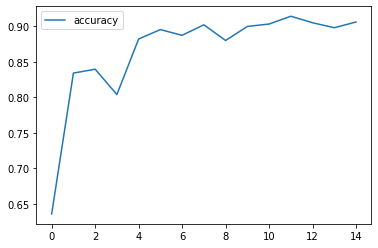

In [21]:
plt.plot(df2["accuracy"])
plt.legend(df2.columns[2:3])

In [22]:
#Train, Test, Accuracy Curves for model2

In [23]:
#Third confusion matrix
print("Confusion-Matrix for model3: covid/non-covid/normal")
print(confusion3)
print("\n")
print("Class-wise accuracies for model3: covid/non-covid/normal")
print(confusion3.diag()/confusion3.sum(1))

Confusion-Matrix for model3: covid/non-covid/normal
tensor([[ 99.,  38.,   2.],
        [  8., 233.,   1.],
        [100.,  37.,  97.]])


Class-wise accuracies for model3: covid/non-covid/normal
tensor([0.7122, 0.9628, 0.4145])


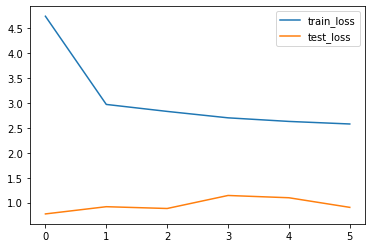

In [24]:
df3 = pd.read_excel("training_logs/model3_all3_1.xlsx")
plt.plot(df3["train_loss"])
plt.plot(df3["test_loss"])
plt.legend(df3.columns[:2])

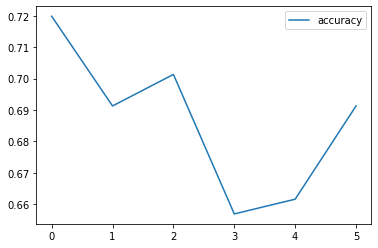

In [25]:
plt.plot(df3["accuracy"])
plt.legend(df3.columns[2:3])

In [26]:
#Train, Test, Accuracy Curves for model1

In [27]:
print("Confusion Matrix for model1->model2 pipeline")
print(confusion_matrix_3)
print("\n")
print("Class-wise accuracies for model1->model2 pipeline")
print(confusion_matrix_3.diag()/confusion_matrix_3.sum(1))

Confusion Matrix for model1->model2 pipeline
tensor([[104.,  29.,   6.],
        [  3., 233.,   6.],
        [ 61.,  39., 134.]])


Class-wise accuracies for model1->model2 pipeline
tensor([0.7482, 0.9628, 0.5726])


In [43]:
label_dict = {0:"Covid", 1:"Non-Covid", 2:"Normal"}

Ground Truth Label: Normal
Predicted Label: Normal


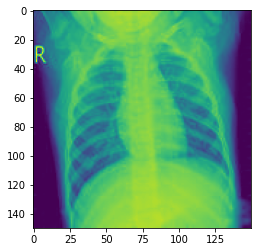

Ground Truth Label: Covid
Predicted Label: Covid


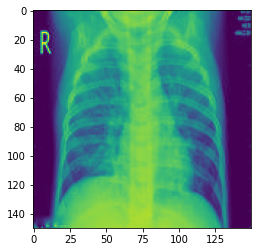

Ground Truth Label: Covid
Predicted Label: Covid


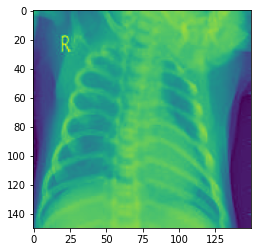

Ground Truth Label: Non-Covid
Predicted Label: Covid


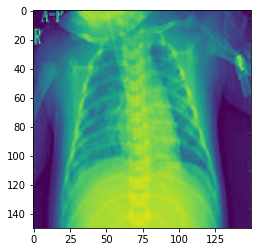

Ground Truth Label: Non-Covid
Predicted Label: Covid


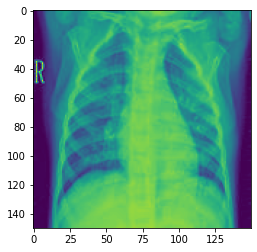

Ground Truth Label: Non-Covid
Predicted Label: Normal


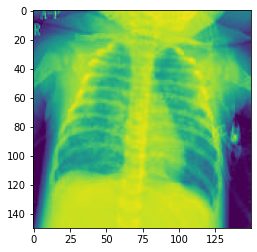

Ground Truth Label: Covid
Predicted Label: Non-Covid


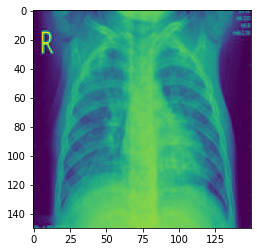

Ground Truth Label: Covid
Predicted Label: Covid


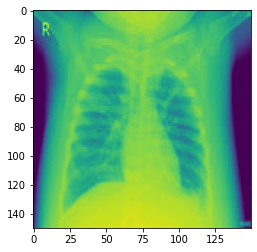

Ground Truth Label: Covid
Predicted Label: Covid


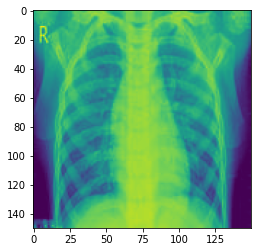

Ground Truth Label: Normal
Predicted Label: Covid


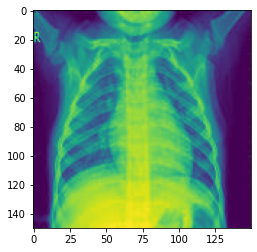

Ground Truth Label: Non-Covid
Predicted Label: Covid


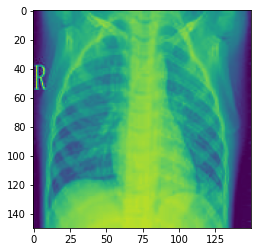

Ground Truth Label: Non-Covid
Predicted Label: Non-Covid


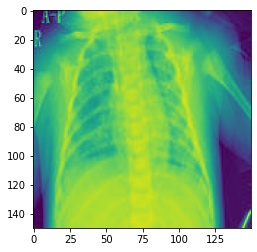

Ground Truth Label: Covid
Predicted Label: Covid


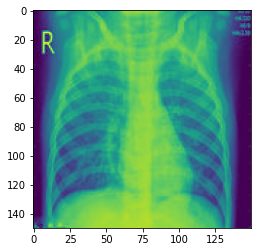

Ground Truth Label: Non-Covid
Predicted Label: Non-Covid


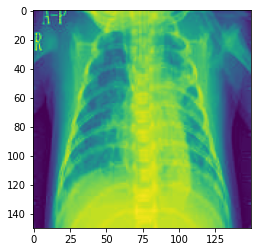

Ground Truth Label: Covid
Predicted Label: Covid


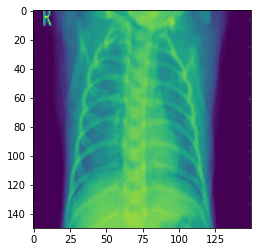

Ground Truth Label: Normal
Predicted Label: Normal


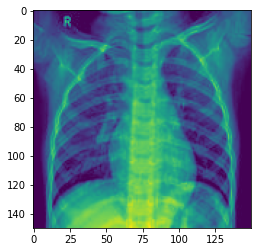

Ground Truth Label: Normal
Predicted Label: Normal


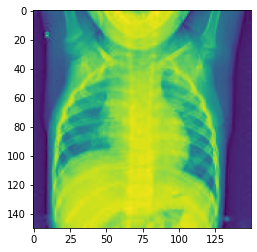

Ground Truth Label: Normal
Predicted Label: Normal


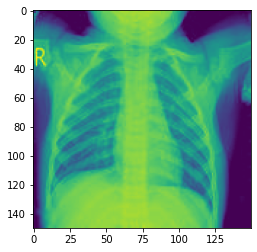

Ground Truth Label: Covid
Predicted Label: Covid


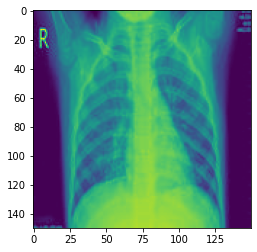

Ground Truth Label: Non-Covid
Predicted Label: Covid


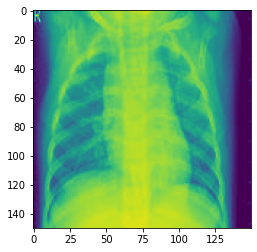

Ground Truth Label: Normal
Predicted Label: Normal


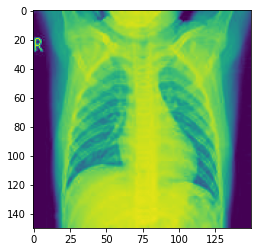

Ground Truth Label: Non-Covid
Predicted Label: Covid


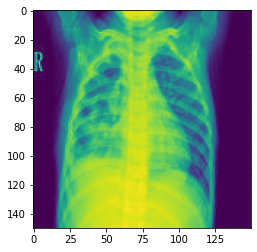

Ground Truth Label: Covid
Predicted Label: Covid


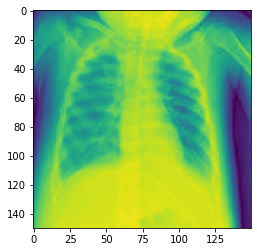

Ground Truth Label: Normal
Predicted Label: Normal


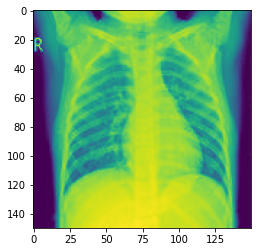

Ground Truth Label: Normal
Predicted Label: Normal


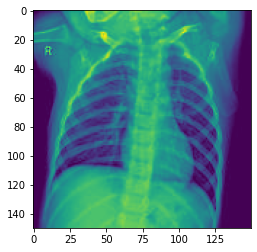

In [54]:
### Visualize results on Validation images

with torch.no_grad():
  for i, (inputs, classes) in enumerate(val_loader3):
      #get model1 output for each input
      outputs = model1(inputs)
      #get model 1 predictions
      _, preds = torch.max(outputs, 1)
      _, y_actual = torch.max(classes, 1)

      #create a 
      preds2 = torch.clone(preds)

      for k in range(len(preds)):
        #if prediction is normal (0), label it as 2
        if preds[k].item() == 0:
          preds2[k] = 2
        else:
          #get model2 output for each input
          model2_output = model2(torch.FloatTensor([inputs[k].numpy()]))
          #get model2 prediction
          _, model2_pred = torch.max(model2_output, 1)
          preds2[k] = model2_pred[0].item()

      for l in range(len(inputs)):
        print("Ground Truth Label: " + label_dict[y_actual[l].item()])
        print("Predicted Label: " + label_dict[preds2[l].item()])
        plt.figure()
        plt.imshow(inputs[l].permute(1, 2, 0).squeeze())
        plt.show()

In [56]:
print("Overall accuracy is: " + str(17/25))

Overall accuracy is: 0.68
